INPUT: Folder/scenario name\
OUTPUT: CSV file with mean reward, stdev, and metadata. Plot of training curve.

In [9]:
import json
import os
import numpy as np
import pandas as pd

sanity_check = True

root_dir = f'../sacred'
search = 'misinform'

def buid_result_df_train(root_dir):
    # Create empty dataframe
    df = pd.DataFrame()

    # Iterate through each folder
    for root, dirs, files in os.walk(root_dir):
        for file in files:

            # Check for eval directory name if running in mode
            if "eval" in os.path.join(root, file):
                continue
        
            if search not in os.path.join(root, file):
                continue

            # Check if info.json and config.json exist
            if 'info.json' in files and 'config.json' in files:
                
                # prints every filename, crude detection of misformed json
                if sanity_check:
                    print(f'{os.path.join(root, file)}')

                # Read the info file
                with open(os.path.join(root, 'info.json')) as info_f:
                    data = json.load(info_f)

                # Read the config file
                with open(os.path.join(root, 'config.json')) as config_f:
                    config = json.load(config_f)

                # Extract return_mean and return_mean_T values from the json
                return_mean = [sample['value'] for sample in data['return_mean']]
                return_std = [sample['value'] for sample in data['return_std']]
                return_mean_T = data['return_mean_T']

                # Put the values in a numpy array
                info_arr = np.array([return_mean_T, return_mean, return_std]).T

                # Convert the numpy array to a pandas dataframe
                df_info = pd.DataFrame(info_arr, columns=['ts', 'return_mean', 'return_stdev'])

                # Loop through the config file and add the variables as columns
                for key, value in config.items():
                    try: 
                        df_info[key] = value
                    except:
                        ValueError(f"Could not read {os.path.join(root, file)}")
                    # Add variables from sub dict
                    if key == 'env_args':
                        for arg_key, arg_val in value.items():
                            df_info[arg_key] = arg_val
                    df_info['path'] = root
                
                # Sanity check:
                for i in df_info['path']:
                    #check if there is at least one corresponding value in column 'ts' that is greater than 990,000
                    if df_info[df_info['path'] == i]['ts'].max() > 990000:
                        pass
                    else:
                        #print("The run at {} did not exceed 990,000 timesteps.".format(i))
                        if file == 'info.json':
                            print(f'This run does not exceed 990,000 timesteps: {os.path.join(root, file)}')
                        break

                # Append file info to dataset
                df = pd.concat([df, df_info])
            elif 'info.json' not in files and file == 'config.json':
                print(f'This run is likely corrupted: {os.path.join(root, file)}')
    return df



df = buid_result_df_train(root_dir)

if df.empty:
    print("No data met the criteria.")
else:
    # rename mac to algorithm
    df.loc[df['mac']=='n_mac', 'mac'] = 'qmix'
    df.loc[df['mac']=='basic_mac', 'mac'] = 'iql'
    df.loc[df['learner']=='ppo_learner', 'mac'] = 'ppo'
    df.loc[(df['map_name'] == 'confidentiality_hard_single') & (df['mac'] == 'iql'), 'mac'] = 'dqn'
    df.rename(columns={'mac': 'algorithm'}, inplace=True)

    df.to_csv(f'../datasets/temp.csv')


../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\1\config.json
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\1\cout.txt
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\1\info.json
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\1\metrics.json
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\1\run.json
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\2\config.json
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\2\cout.txt
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\2\info.json
../sacred\availability_medium_misinform\trg\misinform_iql_cyborg_availability_medium_misinform\2\metrics.json
../sacred\availability_medium_

Some helpful sanity checking

In [8]:
print(df.groupby([ 'algorithm', 'map_name',])['seed'].nunique())

algorithm  map_name                        
iql        availability_medium_misinform       5
           confidentiality_medium_misinform    5
           integrity_medium_misinform          5
qmix       availability_medium_misinform       5
           confidentiality_medium_misinform    5
           integrity_medium_misinform          5
Name: seed, dtype: int64


In [10]:
df_mean = df.groupby(['algorithm', 'map_name'])[['return_mean', 'return_stdev']].mean().reset_index()
df_cv = df_mean.groupby(['algorithm', 'map_name'])[['return_mean', 'return_stdev']].mean().reset_index()

print(df_cv)

  algorithm                          map_name  return_mean  return_stdev
0       iql     availability_medium_misinform   -14.553080     12.095783
1       iql  confidentiality_medium_misinform   -25.610565     16.315505
2       iql        integrity_medium_misinform   -19.809971     14.480967
3      qmix     availability_medium_misinform   -13.769313     11.152931
4      qmix  confidentiality_medium_misinform   -22.618008     18.197638
5      qmix        integrity_medium_misinform   -19.500779     13.776794


Plot Learning Curves

In [18]:
import pandas as pd
df = pd.read_csv('../datasets/baseline_trg.csv')

C:\Users\wiebe\AppData\Local\Temp\ipykernel_25960\3258160308.py:21: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.relplot(data=df_pl,


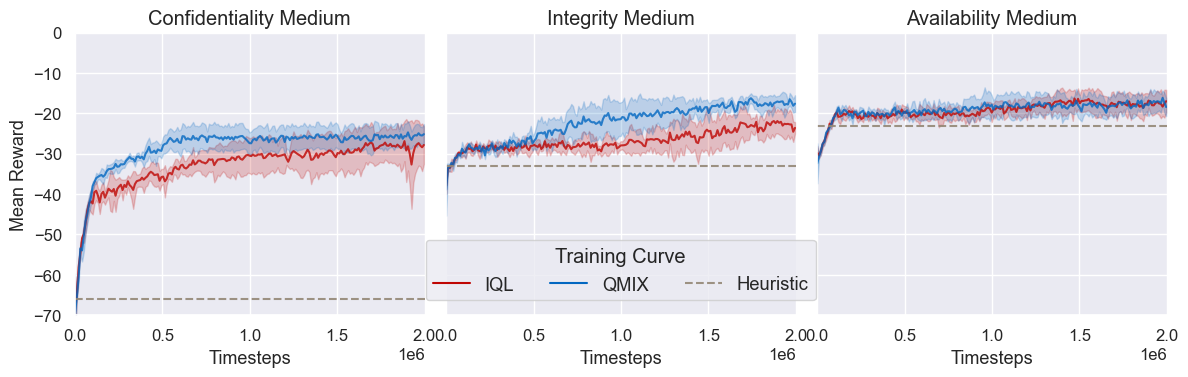

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.lines as mlines

maps_to_display = {'confidentiality_medium': 'Confidentiality Medium',
                   'integrity_medium': 'Integrity Medium',
                   'availability_medium': 'Availability Medium',
                    }

sort_order = list(maps_to_display)

df_h = pd.read_csv('../datasets/heuristic/heuristic_cv.csv')
df_pl = df[df['map_name'].isin(maps_to_display.keys())]
df_pl.sort_values(by='map_name', key=lambda x: x.map(lambda val: sort_order.index(val)), inplace=True)


sns.set(style='darkgrid')
sns.set_context("notebook",  font_scale=1.2, rc={"xtick.labelsize":12, "ytick.labelsize":12, "axes.labelsize":13})
# Plot facets
g = sns.relplot(data=df_pl, 
                x='ts', y='return_mean', 
                hue='algorithm', style='algorithm', kind='line', 
                legend=None, sort=True, 
                dashes=False, markers=False, 
                alpha=0.8, height=4, aspect=1,
                errorbar='sd', 
                palette=['#BF0603',  '#0267C1', '#136F63', '#9A5B8B', ], 
                col='map_name',
                #estimator='median'
                )


for i, ax in enumerate(g.axes.flatten()):
    heuristic_mean = df_h[df_h['map_name']==sort_order[i]]['return_mean'].values[0]
    ax.axhline(heuristic_mean, ls='--', color='#948776', alpha=0.9)

g.set(xlabel='Timesteps', ylabel='Mean Reward')
g.set(xlim=(0, 2000000))
g.set(ylim=(-70, 0))

# Make a custom legend
iql_line = mlines.Line2D([], [], color='#BF0603')
qmix_line = mlines.Line2D([], [], color='#0267C1')
heuristic_line = mlines.Line2D([],[], linestyle='--', color='#948776', alpha=0.9)
dqn_line = mlines.Line2D([], [], color='#9A5B8B')
ppo_line = mlines.Line2D([], [], color='#136F63')


#handles = [iql_line, qmix_line, dqn_line, ppo_line]
#labels = ['IQL', 'QMIX', 'DQN', 'PPO']
handles = [iql_line, qmix_line, heuristic_line]
labels = ['IQL', 'QMIX', 'Heuristic']

plt.legend(title="Training Curve", 
            frameon=True, ncol=3,
            #bbox_to_anchor=(0.8, 0.3),
            #bbox_to_anchor=(0.27, 0.45), 
            bbox_to_anchor=(0.022, 0.3), 
            
            handles=handles, labels=labels
            )

titles = [title for title in maps_to_display.values()]

for i, ax in enumerate(g.axes.flat):
    ax.set_title(titles[i])

In [15]:
import pandas as pd
df = pd.read_csv('../datasets/misinform_trg.csv')

C:\Users\wiebe\AppData\Local\Temp\ipykernel_25960\3258160308.py:21: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  g = sns.relplot(data=df_pl,


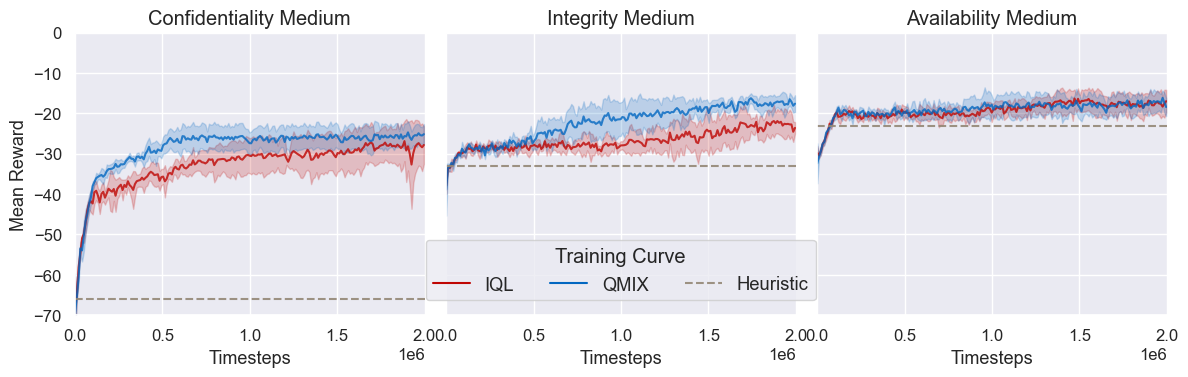

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.lines as mlines

maps_to_display = {'confidentiality_medium': 'Confidentiality Medium',
                   'integrity_medium': 'Integrity Medium',
                   'availability_medium': 'Availability Medium',
                    }
maps_to_display = {'confidentiality_medium_misinform': 'Confidentiality Medium (Misinform)',
                   'integrity_medium_misinform': 'Integrity Medium (Misinform)',
                   'availability_medium_misinform': 'Availability Medium (Misinform)',
                    }
sort_order = list(maps_to_display)

df_h = pd.read_csv('../datasets/heuristic/misinform_heuristic_cv.csv')
df_pl = df[df['map_name'].isin(maps_to_display.keys())]
df_pl.sort_values(by='map_name', key=lambda x: x.map(lambda val: sort_order.index(val)), inplace=True)


sns.set(style='darkgrid')
sns.set_context("notebook",  font_scale=1.2, rc={"xtick.labelsize":12, "ytick.labelsize":12, "axes.labelsize":13})
# Plot facets
g = sns.relplot(data=df_pl, 
                x='ts', y='return_mean', 
                hue='algorithm', style='algorithm', kind='line', 
                legend=None, sort=True, 
                dashes=False, markers=False, 
                alpha=0.8, height=4, aspect=1,
                errorbar='sd', 
                palette=['#BF0603',  '#0267C1', '#136F63', '#9A5B8B', ], 
                col='map_name',
                #estimator='median'
                )


for i, ax in enumerate(g.axes.flatten()):
    heuristic_mean = df_h[df_h['map_name']==sort_order[i]]['return_mean'].values[0]
    ax.axhline(heuristic_mean, ls='--', color='#948776', alpha=0.9)

g.set(xlabel='Timesteps', ylabel='Mean Reward')
g.set(xlim=(0, 2000000))
g.set(ylim=(-70, 0))

# Make a custom legend
iql_line = mlines.Line2D([], [], color='#BF0603')
qmix_line = mlines.Line2D([], [], color='#0267C1')
heuristic_line = mlines.Line2D([],[], linestyle='--', color='#948776', alpha=0.9)
dqn_line = mlines.Line2D([], [], color='#9A5B8B')
ppo_line = mlines.Line2D([], [], color='#136F63')


#handles = [iql_line, qmix_line, dqn_line, ppo_line]
#labels = ['IQL', 'QMIX', 'DQN', 'PPO']
handles = [iql_line, qmix_line, heuristic_line]
labels = ['IQL', 'QMIX', 'Heuristic']

plt.legend(title="Training Curve", 
            frameon=True, ncol=3,
            #bbox_to_anchor=(0.8, 0.3),
            #bbox_to_anchor=(0.27, 0.45), 
            bbox_to_anchor=(0.022, 0.3), 
            
            handles=handles, labels=labels
            )

titles = [title for title in maps_to_display.values()]

for i, ax in enumerate(g.axes.flat):
    ax.set_title(titles[i])

In [11]:
df.to_csv('../datasets/misinform_trg.csv')
df_cv.to_csv('../datasets/misinform_trg_cv.csv')

Get heuristic data

In [6]:
df_conv = df.loc[df['ts'] == 998160.0][['algorithm', 'map_name', 'return_stdev', 'return_mean']]

df_mean = df_conv.groupby([['algorithm', 'map_name']])['return_mean', 'return_stdev'].mean().reset_index()


print(df_mean)

#df_mean.to_csv('./datasets/phase1_1M_stdev.csv')

#stdev = df_conv.loc[df_conv['ts'], 'return_stdev']
#print('Stdev:', stdev)

ValueError: Grouper and axis must be same length

In [23]:
def within_one_stdev(row):
    iql_mean = row['return_mean']
    qmix_mean = row['return_mean']
    stdev = row['return_stdev']
    if abs(iql_mean - qmix_mean) <= stdev:
        return True
    else:
        return False

df_mean['within_one_stdev'] = df.apply(within_one_stdev, axis=1)
print(df_mean)

   algorithm                map_name  return_mean  return_stdev  \
0        iql       availability_easy    -3.389821      3.278751   
1        iql       availability_hard    -3.850000      2.437045   
2        iql     availability_medium   -36.569702     26.261451   
3        iql    confidentiality_easy  -166.328988     55.769792   
4        iql    confidentiality_hard   -44.847857     24.223731   
5        iql  confidentiality_medium   -80.001190     38.443653   
6        iql          integrity_easy   -99.340417     51.958131   
7        iql          integrity_hard   -12.679702      6.364152   
8        iql        integrity_medium   -14.955893     13.914883   
9       qmix       availability_easy    -4.080060      3.362486   
10      qmix       availability_hard    -3.493899      2.215589   
11      qmix     availability_medium   -37.124603     26.517726   
12      qmix    confidentiality_easy  -225.301012     13.406933   
13      qmix    confidentiality_hard   -44.222857     23.16844